Imports

In [1]:
import utils.scrape_no_js as bourso
import utils.inputs as inputs
import utils.helper_functions as hf

from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Config

In [2]:
buy_time = 'Open'
loss_limit = 0.997

cumulated_probs_target = 0.9

fee = 0.002

download_days = 500 #should be > 151 = 90 (input days) * 7/5 (days per week) * 1.2 (margin in case of vacations)

model_path = './outputs/classifier_model.keras'
scaler_path = './outputs/scaler.pkl'

In [3]:
tickers_file_path = './db/tickers_euronext_regulated_euro_500k€.xlsx'
df_tickers = pd.read_excel(tickers_file_path)

num_tickers = len(df_tickers)
print(f'number of tickers: {num_tickers}')

number of tickers: 854


Download past data

In [4]:
def get_past_date(days_past):
    today = date.today()
    past_date = today - timedelta(days=days_past)
    formatted_date = past_date.strftime('%Y-%m-%d')
    return formatted_date

def days_difference(date1, date2): # can handle date objects and 'YYYY-MM-DD' strings
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)

    difference = abs((date2 - date1).days)
    return difference

In [5]:
start_date = get_past_date(download_days)
today = get_past_date(0)

print(f'start download date: {start_date}')
print(f'today: {today}')

start download date: 2023-03-05
today: 2024-07-17


In [6]:
yahoo_tickers = df_tickers['yahoo'].iloc[1:num_tickers+1].values.tolist()

download_past_data = yf.download(yahoo_tickers, start=start_date, end=today)
df_download_past = pd.DataFrame(download_past_data)
df_download_past_filled = hf.fillnavalues(df_download_past)
# df_download = df_download.dropna(axis='columns', how='all') #remove columns with only nan values

print(df_download_past_filled.tail(3).to_markdown())


[*********************100%%**********************]  853 of 853 completed

3 Failed downloads:
['WTFIN.MI', 'NAIW.AS', 'BNJW.AS']: Exception('%ticker%: No timezone found, symbol may be delisted')


| Date                |   ('Adj Close', 'A2A.MI') |   ('Adj Close', 'AAA.PA') |   ('Adj Close', 'AALB.AS') |   ('Adj Close', 'AB.PA') |   ('Adj Close', 'ABCA.PA') |   ('Adj Close', 'ABEO.PA') |   ('Adj Close', 'ABI.BR') |   ('Adj Close', 'ABN.AS') |   ('Adj Close', 'ABNX.PA') |   ('Adj Close', 'ABO.BR') |   ('Adj Close', 'ABT.MI') |   ('Adj Close', 'ABVX.PA') |   ('Adj Close', 'AC.PA') |   ('Adj Close', 'AC5.MI') |   ('Adj Close', 'ACA.PA') |   ('Adj Close', 'ACAN.PA') |   ('Adj Close', 'ACCB.BR') |   ('Adj Close', 'ACE.MI') |   ('Adj Close', 'ACKB.BR') |   ('Adj Close', 'AD.AS') |   ('Adj Close', 'ADB.MI') |   ('Adj Close', 'ADOC.PA') |   ('Adj Close', 'ADP.PA') |   ('Adj Close', 'ADYEN.AS') |   ('Adj Close', 'AED.BR') |   ('Adj Close', 'AEDES.MI') |   ('Adj Close', 'AEF.MI') |   ('Adj Close', 'AELIS.PA') |   ('Adj Close', 'AF.PA') |   ('Adj Close', 'AFME.PA') |   ('Adj Close', 'AGFB.BR') |   ('Adj Close', 'AGN.AS') |   ('Adj Close', 'AGS.BR') |   ('Adj Close', 'AI.PA') |   ('Adj Clos

In [7]:
last_index = df_download_past_filled.index[-1]
last_download_past_date = last_index.date()
print(f'last download date: {last_download_past_date}')

download_missing_days = days_difference(today, last_download_past_date)
print(f'download missing days: {download_missing_days}')

# if download_missing_days > 1:
#     raise ValueError("Too many download missing days")


last download date: 2024-07-16
download missing days: 1


Download today's data

In [8]:
bourso_tickers = df_tickers['bourso'].iloc[1:num_tickers+1].values.tolist()

df_download_today = bourso.get_theoretical_opening_prices(bourso_tickers)

print(df_download_today)

         ticker  theoretical_opening_price
0        1rAAGN                     5.7940
1       1rAAJAX                    10.3500
2      1rAAMUND                     1.3000
3        1rAALX                     1.2600
4       1rAAZRN                     1.6000
5      1rAAZRNW                        NaN
6       1rABSGR                     4.7950
7        1rABNJ                     8.7500
8       1rABNJW                        NaN
9       1rABESI                   168.8000
10       1rABAI                     0.6200
11      1rABAIW                        NaN
12      1rABGHL                    27.0000
13      1rABRNL                    10.5200
14     1rACABKA                     3.6400
15     1rACMCOM                     7.1500
16      1rACRBN                    18.5000
17      1rACTAC                     3.0900
18       1rACVC                    17.5200
19       1rADGB                     0.7100
20     1rAEAS2P                     0.5600
21      1rAEBUS                     1.4300
22      1rA

Transform past data

In [9]:
def get_single_level_df(df, ohlcv):
    new_df = df[[ohlcv]]
    new_df = hf.remove_top_column_name(new_df)

    return new_df

def get_ohlcv_dfs(df):
    df_open = get_single_level_df(df, 'Open')
    df_high = get_single_level_df(df, 'High')
    df_low = get_single_level_df(df, 'Low')
    df_close = get_single_level_df(df, 'Close')
    df_volume = get_single_level_df(df, 'Volume')
    
    return {'df_open': df_open, 'df_high': df_high, 'df_low': df_low,
            'df_close': df_close, 'df_volume': df_volume}

In [10]:
list_dfs_ohlcv = get_ohlcv_dfs(df_download_past_filled)
df_buy = get_single_level_df(df_download_past_filled, buy_time)

print(df_buy.tail(3).to_markdown())

| Date                |   A2A.MI |   AAA.PA |   AALB.AS |   AB.PA |   ABCA.PA |   ABEO.PA |   ABI.BR |   ABN.AS |   ABNX.PA |   ABO.BR |   ABT.MI |   ABVX.PA |   AC.PA |   AC5.MI |   ACA.PA |   ACAN.PA |   ACCB.BR |   ACE.MI |   ACKB.BR |   AD.AS |   ADB.MI |   ADOC.PA |   ADP.PA |   ADYEN.AS |   AED.BR |   AEDES.MI |   AEF.MI |   AELIS.PA |   AF.PA |   AFME.PA |   AGFB.BR |   AGN.AS |   AGS.BR |   AI.PA |   AIR.PA |   AJAX.AS |   AKE.PA |   AKOM.PA |   AKW.PA |   AKZA.AS |   ALFEN.AS |   ALK.MI |   ALLFG.AS |   ALO.PA |   ALTA.PA |   ALTR.LS |   ALW.MI |   ALX.AS |   AM.PA |   AMG.AS |   AMP.MI |   AMPLI.PA |   AMUN.PA |   AMUND.AS |   ANIM.MI |   ANTIN.PA |   APAM.AS |   ARAMI.PA |   ARCAD.AS |   AREIT.PA |   ARG.PA |   ARGX.BR |   ARIS.MI |   ARN.MI |   ARTE.PA |   ARTO.PA |   ARVBS.PA |   ARVEN.PA |   ASC.MI |   ASCE.BR |   ASM.AS |   ASML.AS |   ASRNL.AS |   ASY.PA |   ATE.PA |   ATEB.BR |   ATEME.PA |   ATLD.PA |   ATO.PA |   AUB.PA |   AUGR.PA |   AURE.PA |   AUTME.MI |   AV.MI 

Transform today's data

In [11]:
mapping_dict = dict(zip(df_tickers['bourso'], df_tickers['yahoo']))

df_download_today['ticker'] = df_download_today['ticker'].map(mapping_dict)

print(df_download_today.tail(5))


       ticker  theoretical_opening_price
848  VLTSA.PA                       9.73
849     VU.PA                     142.00
850     MF.PA                      83.90
851    WLN.PA                      10.30
852   XFAB.PA                       6.48


In [12]:
df_buy_today = df_download_today.set_index('ticker').T
df_buy_today.index = ['Date']

today_date = datetime.now().strftime("%Y-%m-%d 00:00:00")
df_buy_today.index = [datetime.strptime(today_date, "%Y-%m-%d %H:%M:%S")]
df_buy_today = df_buy_today.reindex(sorted(df_buy_today.columns), axis=1)

print(df_buy_today)

ticker      A2A.MI  AAA.PA  AALB.AS  AB.PA  ABCA.PA  ABEO.PA  ABI.BR  ABN.AS  \
2024-07-17    1.87     8.0      NaN   1.01     3.99     10.8    54.4     NaN   

ticker      ABNX.PA  ABO.BR  ABT.MI  ABVX.PA  AC.PA  AC5.MI  ACA.PA  ACAN.PA  \
2024-07-17     1.24    5.55    4.29    12.66   38.9    1.98    13.7    0.383   

ticker      ACCB.BR  ACE.MI  ACKB.BR  AD.AS  ADB.MI  ADOC.PA  ADP.PA  \
2024-07-17   0.0295   15.49    170.7    NaN    7.92     5.87   120.5   

ticker      ADYEN.AS  AED.BR  AEDES.MI  AEF.MI  AELIS.PA  AF.PA  AFME.PA  \
2024-07-17       NaN   59.75     0.212   0.772      12.0   8.04      2.0   

ticker      AGFB.BR  AGN.AS  AGS.BR   AI.PA  AIR.PA  AJAX.AS  AKE.PA  AKOM.PA  \
2024-07-17     1.18   5.794    43.1  162.02   131.0    10.35    81.0      2.8   

ticker      AKW.PA  AKZA.AS  ALFEN.AS  ALK.MI  ALLFG.AS  ALO.PA  ALTA.PA  \
2024-07-17    11.0      NaN       NaN    12.1       NaN   17.55     92.5   

ticker      ALTR.LS  ALW.MI  ALX.AS  AM.PA  AMG.AS  AMP.MI  AMPL

Transform: Create inputs

In [14]:
df_inputs = inputs.get_inputs(df_buy, list_dfs_ohlcv)

last_day_index = df_inputs.index.get_level_values(0)[-1] # Get the last value in the top-level index
df_inputs_last_day = df_inputs.loc[last_day_index]

X_inputs_last_day = df_inputs_last_day.values # Convert DataFrame to numpy array

print(df_inputs_last_day.tail(3).to_markdown())

| Ticker   |   input_var_past_90d_future_0d |   input_var_past_60d_future_0d |   input_var_past_30d_future_0d |   input_var_past_10d_future_0d |   input_var_past_5d_future_0d |   input_var_past_2d_future_0d |   input_var_past_1d_future_0d |   input_var_past_close_1d |   input_var_past_high_1d |   input_var_past_low_1d |   input_volume_var_90-1d |   input_volume_var_60-1d |   input_volume_var_30-1d |   input_volume_var_10-1d |   input_volume_var_2-1d |   input_volume_var_3-1d |   input_min_var_past_90d |   input_min_var_past_30d |   input_min_var_past_10d |   input_min_var_past_5d |   input_min_var_past_2d |   input_max_var_past_90d |   input_max_var_past_30d |   input_max_var_past_10d |   input_max_var_past_5d |   input_max_var_past_2d |   input_days_since_min_30d |   input_days_since_min_10d |   input_days_since_max_30d |   input_days_since_max_10d |   input_volatility_30d |   input_volatility_10d |   input_volatility_2d |   input_volume_volatility_90d |   input_volume_volatility_30d 

In [15]:
print(f'shape of X_inputs_last_day (rows -> tested data, columns -> inputs): {X_inputs_last_day.shape}')

shape of X_inputs_last_day (rows -> tested data, columns -> inputs): (853, 52)


In [16]:
scaler = hf.load_object(scaler_path)

X_inputs_last_day_scaled = scaler.transform(X_inputs_last_day)

Load model

In [17]:
model = tf.keras.models.load_model(model_path)

Predict

In [18]:
prediction = model.predict(X_inputs_last_day_scaled)
df_prediction = pd.DataFrame(prediction, columns=['buy', 'do_not_buy'], index=df_inputs_last_day.index)
# df_prediction = df_prediction['buy']
df_prediction = df_prediction.sort_values(by='do_not_buy')


print(df_prediction.to_markdown())


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
| Ticker   |        buy |   do_not_buy |
|:---------|-----------:|-------------:|
| OXUR.BR  |   0.988108 |    0.0118919 |
| SCR.PA   |   0.986706 |    0.0132944 |
| CYAD.BR  |   0.963954 |    0.0360457 |
| XPR.MI   |   0.963566 |    0.0364345 |
| S24.MI   |   0.916145 |    0.0838553 |
| GRVO.PA  |   0.903532 |    0.0964681 |
| MTV.MI   |   0.898753 |    0.101247  |
| PARRO.PA |   0.882361 |    0.117639  |
| ITM.MI   |   0.851341 |    0.148659  |
| RN.MI    |   0.848087 |    0.151913  |
| FDA.MI   |   0.844696 |    0.155304  |
| CENER.BR |   0.811332 |    0.188668  |
| GVS.MI   |   0.796871 |    0.203129  |
| SERI.MI  |   0.793008 |    0.206992  |
| OREGE.PA |   0.792989 |    0.207011  |
| ONWD.BR  |   0.789433 |    0.210567  |
| CNDF.PA  |   0.769988 |    0.230012  |
| TRACT.PA |   0.752005 |    0.247995  |
| DEX.MI   |   0.750894 |    0.249106  |
| ABEO.PA  |   0.743402 |    0.256598  |
| INPST.AS |   0.742593 |    0.257407  |
| ALFEN.AS |   0.7

Evaluate

In [19]:
df_open = list_dfs_ohlcv['df_open']
df_close = list_dfs_ohlcv['df_close']

df_open_last_day = df_open.loc[last_day_index]
df_close_last_day = df_close.loc[last_day_index]

df_real = pd.DataFrame()
df_real['variation'] = df_close_last_day / df_open_last_day

In [20]:
df_low = list_dfs_ohlcv['df_low']
df_low_last_day = df_low.loc[last_day_index]
df_real['lowest_variation'] = df_low_last_day / df_open_last_day

df_real['profit'] = df_real['variation']
df_real.loc[df_real['lowest_variation'] < loss_limit, 'profit'] = loss_limit
df_real['profit'] *= hf.get_fee_coef(fee)

In [21]:
df_evaluation = pd.concat([df_prediction, df_real], axis='columns')
print(df_evaluation)

               buy  do_not_buy  variation  lowest_variation    profit
Ticker                                                               
OXUR.BR   0.988108    0.011892   1.000000          1.000000  0.996008
SCR.PA    0.986706    0.013294   0.905991          0.844700  0.993020
CYAD.BR   0.963954    0.036046   1.070000          1.000000  1.065729
XPR.MI    0.963566    0.036434   0.996721          0.973771  0.993020
S24.MI    0.916145    0.083855   1.036517          1.000000  1.032379
GRVO.PA   0.903532    0.096468   1.013216          1.000000  1.009171
MTV.MI    0.898753    0.101247   1.025424          1.000000  1.021330
PARRO.PA  0.882361    0.117639   1.000000          1.000000  0.996008
ITM.MI    0.851341    0.148659   1.006981          1.000000  1.002961
RN.MI     0.848087    0.151913   1.022876          1.000000  1.018793
FDA.MI    0.844696    0.155304   1.026786          1.000000  1.022687
CENER.BR  0.811332    0.188668   1.015306          1.000000  1.011253
GVS.MI    0.796871  

In [22]:
df_filtered_evaluation = df_evaluation[df_evaluation['buy'] > cumulated_probs_target]

count = df_filtered_evaluation['profit'].count()
average = df_filtered_evaluation['profit'].mean()
median = df_filtered_evaluation['profit'].median()

print(f'count: {count}')
print(f'average profit: {average}')
print(f'median profit: {median}')

count: 6
average profit: 1.0148877601130122
median profit: 1.0025895176282615


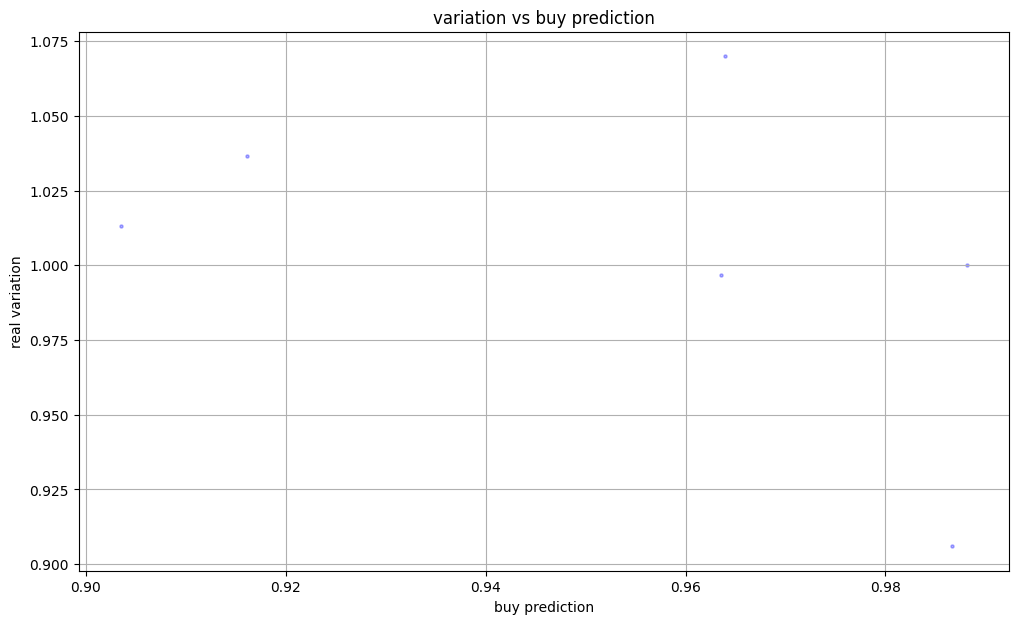

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.scatter(x=df_filtered_evaluation['buy'], y=df_filtered_evaluation['variation'], color='blue', alpha=0.3, s=5)
plt.title('variation vs buy prediction')
plt.xlabel('buy prediction')
plt.ylabel('real variation')
plt.grid(True)
plt.show()